In [1]:
from IPython.display import clear_output

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch 2.0.1 which is incompatible.


In [3]:
!pip install -q bitsandbytes datasets accelerate loralib evaluate jiwer

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cuda 22.4.0 requires click==8.0.4, but you have click 8.1.7 which is incompatible.
s3fs 2022.3.0 requires fsspec==2022.3.0, but you have fsspec 2023.6.0 which is incompatible.


In [ ]:
!pip install matplotlib seaborn

In [4]:
!nvidia-smi # GPU information

Tue Sep 19 11:14:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   24C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from datasets import load_dataset

### Get the dataset

In [7]:
from huggingface_hub import login

In [10]:
use_auth_token = '' # generate the token in hugging face and pass it
login(use_auth_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/jovyan/.cache/huggingface/token
Login successful


In [11]:
data = load_dataset("JairamKanna/data")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6174 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1764 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/883 [00:00<?, ? examples/s]

In [12]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['label', 'input_features'],
        num_rows: 6174
    })
    test: Dataset({
        features: ['label', 'input_features'],
        num_rows: 1764
    })
    valid: Dataset({
        features: ['label', 'input_features'],
        num_rows: 883
    })
})


### Get the model

In [13]:
from transformers import AutoProcessor, AutoModelForAudioClassification

In [14]:
# Select CUDA device index
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# model using to train 
model_name_or_path = "openai/whisper-large-v2"

processor = AutoProcessor.from_pretrained(model_name_or_path)

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


with the hugging face version at the time of writing the paper, there is a bug and code won't work if we don't have labels till 32  
in the future versions we can change the below cell to include correct labels without dummy labels

In [15]:
# classes in the dataset. in future versions no need to include dummy variables till 32
labels = ["Andhra", "Gujrat", "Jharkhand", "Karnataka", "Kerala", "Tamil", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32"] # 

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
from tranformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [16]:
# loading model for Audio classification and converting it into 8-bit
model = AutoModelForAudioClassification.from_pretrained(
    model_name_or_path, 
    load_in_4bit=True, 
    device_map="auto", 
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,) 

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v2 and are newly initialized: ['model.classifier.bias', 'model.projector.bias', 'model.projector.weight', 'model.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Getting peft model

convert the transformer model to peft model to fit into small GPUs

In [17]:
from peft import prepare_model_for_int8_training, prepare_model_for_kbit_training
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

 
# assign different rank values in the parameter "r", we used rank values 32,24,16,8,4, and 2 
config = LoraConfig(r=32, 
                    lora_alpha=64, 
                    target_modules=["q_proj", "v_proj"], 
                    lora_dropout=0.05, 
                    bias="none")

model = prepare_model_for_int8_training(model) 
model = get_peft_model(model, config)
model.print_trainable_parameters()

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/peft/utils/other.py:133: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 5,242,880 || all params: 642,363,680 || trainable%: 0.8161856224498869


#### set evaluation metrics for training

In [18]:
import evaluate
accuracy = evaluate.load("accuracy")


import numpy as np
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

### Training

In [19]:
from transformers import TrainingArguments, Trainer

In [20]:
training_args = TrainingArguments(
    output_dir="output",  
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3, # try 1e-5, 3e-5, 5e-5 (MOST IMPORTANT HYPERPARAMETER FOR LORA)
    warmup_ratio=0.1,
    num_train_epochs=10, # training for 10 epochs
    # max_steps = 1000,
    evaluation_strategy="no",
    fp16=True,
    per_device_eval_batch_size=8,
    logging_strategy='epoch',
    # logging_steps=5,
    remove_unused_columns=False,  # required as the PeftModel forward doesn't have the signature of the wrapped model's forward
    label_names=["label"],  # same reason as above
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["test"],
    eval_dataset=data["valid"],
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

trainer.train()

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
772,1.323400
1544,0.183300
2316,0.082300
3088,0.082500
3860,0.059800
4632,0.052800
5404,0.040000
6176,0.046900
6948,0.039500
7720,0.037900


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatM

TrainOutput(global_step=7720, training_loss=0.1948333409166089, metrics={'train_runtime': 98240.0815, 'train_samples_per_second': 0.628, 'train_steps_per_second': 0.079, 'total_flos': 5.6939029636608e+19, 'train_loss': 0.1948333409166089, 'epoch': 10.0})

### Evaluating 

In [1]:
preds_prob = trainer.predict(data["train"]) # get the prediction probabilities for the test set for each class

NameError: name 'trainer' is not defined

In [22]:
predictions = np.argmax(preds_prob.predictions[1], axis=1) # get the index of the max probability

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(classification_report(data["train"]["label"], predictions))

ValueError: Found input variables with inconsistent numbers of samples: [883, 1764]

In [26]:
cm = confusion_matrix(data["train"]["label"], predictions)

In [27]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


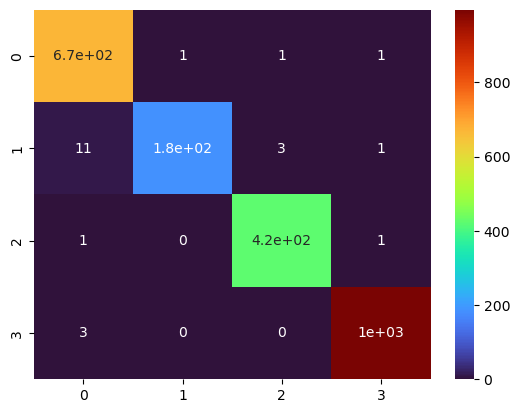

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fx = sns.heatmap(cm, annot=True, cmap='turbo')
plt.show()

### send model to hugging face hub 

In [ ]:
from huggingface_hub import notebook_login

notebook_login

In [ ]:
Account_name = "" # give your account name
Model_name = "" # give the model name

model.push_to_hub(f"{Account_name}/{Model_name}")